# Analysys of the Segmentation Results 

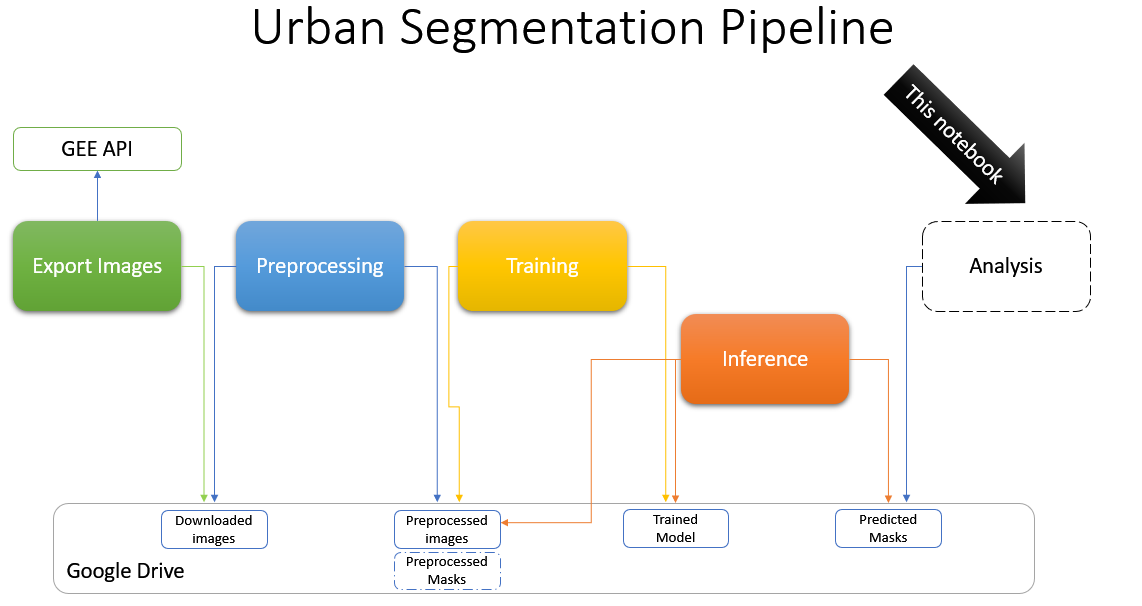

This notebook contains the Segmentation pipeline results analysis using fastai
It assumes that the dataset was already preprocessed and available in two directories:
- s2_resized - the input images
- esm_aligned - the ESM masks

A model was trained and saved: `models/best_model.pt`

Results file: `results_log.csv`

Test data and predidictions:
- s2_resized_test - images for test not used in training
- esm_resized_test - masks of the above test images (unused)
- preds - predicted masks based on test data


# Setup

In [56]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!pip install geemap fastai rasterio pytorch-ignite torchmetrics -q

In [58]:
# Python General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil

from pathlib import Path
import glob
from tqdm.notebook import tqdm
import pprint as pp
from PIL import Image
import numpy as np

#Torch
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.resnet import resnet18,resnet34,resnet50,resnet101

#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from fastai.data.transforms import get_image_files, Normalize


import ee
import geemap
from ipyleaflet import Map, basemaps

In [59]:
DRV = '/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/'

#Image assets on GEE (jul26 saitama preds)
list_imgs = []
for i in range(1,50):
  list_imgs.append('projects/ee-liadleviraz/assets/pred_s2_img_'+str(i))
print(list_imgs[-3:])

['projects/ee-liadleviraz/assets/pred_s2_img_47', 'projects/ee-liadleviraz/assets/pred_s2_img_48', 'projects/ee-liadleviraz/assets/pred_s2_img_49']


In [60]:
if not Map:
  Map.clear()
center = [35.89,139.59]
zoom = 11.4

# Map = geemap.Map(basemap=basemaps.Gaode.Satellite, center=center, zoom=zoom) #zoom > 7 doesn't show
#after you see the map change the map baseline to 'Satellite' on the Menu
Map = geemap.Map(center=center, zoom=zoom)

#Uncomment to use our exported image of saitama
rgb_img_asset = 'projects/ee-liadleviraz/assets/saitama_area2'
bg_img = ee.Image(rgb_img_asset)
rgb_img = ee.Image(bg_img.select(['B2','B3','B4']))
Map.addLayer(rgb_img, vis_params={  'min': 0,  'max': 3000}, name=rgb_img_asset,opacity=1)

for i,img_path in enumerate(list_imgs):
  dataset = ee.Image(img_path)
  b1 = ee.Image(dataset.select('b1'))
  resi_mask = b1.select('b1').gt(1);
  Map.addLayer(resi_mask, {'palette': ['red', 'green']}, '250-255-mask'+str(i));

Map

Map(center=[35.89, 139.59], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [61]:
#location of the dataset
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
NB_DIR = '/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks'
sys.path.append(NB_DIR)

ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'


esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(EXPORT_DIR,'s2_resized')
S2_TEST_DIR = s2_resized + '_test'
ESM_TEST_DIR = esm_aligned + '_test'


In [62]:
from libs.training import *
from libs.inference import *

In [63]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
tst = glob.glob(os.path.join(S2_TEST_DIR,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,S2_TEST_DIR))

640 train files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized
60 test files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test


### Classes codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [64]:
codes = ['0_No_Data','1_Land','250_Non_Resi_BU','255_Resi_BU']
codes

['0_No_Data', '1_Land', '250_Non_Resi_BU', '255_Resi_BU']

In [65]:
# From np.unique(mask)
mask_vals = {0:0,1:1,2:250,3:255}
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}

In [66]:
fnames = get_image_files(s2_resized)
lbl_names = get_image_files(esm_aligned)
fnames,lbl_names

((#640) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_1.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_2.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_4.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_5.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_9.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_6.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_11.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_10.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_7.tif')...],
 (#640) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),Path('/content/dr

In [67]:
code2class = {0:0,1:250,2:255}
class2code={0:0,250:1,255:2}
class2desc={0:'Other',250:'Non Resi',255:'Resi'}
img_fn = fnames[3].name
msk = get_mask_as_array(img_fn,esm_aligned,code2class)[1]

In [68]:
cm='brg_r' #'nipy_spectral_r'

In [69]:
msk2 = get_mask_as_array(img_fn,esm_aligned,mask_vals,merge_bg=True)[1]
np.unique(msk,return_counts=True),np.unique(msk2,return_counts=True)

((array([0, 1, 2]), array([52849,   180, 36971])),
 (array([0, 1, 2, 3]), array([  293, 52556,   180, 36971])))

In [70]:
msk.shape,msk2.shape

(torch.Size([300, 300]), torch.Size([300, 300]))

In [71]:
def get_counts(a,b):
  print('\n counts:',a.shape,b.shape)
  print(np.unique(tensor(a),return_counts=True),'\n',np.unique(tensor(b),return_counts=True))

def prep_hist_no_bg(inp,targ):
  '''
  prepare tensors for evaluation
  '''
  get_counts(inp,targ)

  targ[targ == 0]=1
  targ[0,0]=0
  inp[inp == 0]=1
  inp[0,0]=0
  targ2=targ.type(torch.IntTensor)
  inp2=inp.type(torch.IntTensor)
  
  get_counts(inp2,targ2)
  
  targ = targ2.squeeze(1).cpu()
  pred=inp2.squeeze(1).cpu()#.argmax(dim=1).cpu()
  n_clss=len(np.unique(inp2))
  
  print('\nn_cls=',n_clss,targ.shape,pred.shape)
  hist = torch.zeros((n_clss, n_clss)).cpu()
  for t, p in zip(targ, pred):
      hist += _fast_hist(t.flatten(), p.flatten(), n_clss)
  print(hist)
  return hist

In [72]:
def dice_coefficient_no_bg(hist):
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

In [73]:
def parse_file_name(full_path):
  return full_path.split(os.path.sep)[-1]

In [74]:
def plot_predictions(path2plot):
  
  sait = glob.glob(os.path.join(path2plot,'*.tif'))
  sait = sorted(sait)
  print(len(sait))
  f,axs = plt.subplots(7,7,figsize=(25,25))
  im_no = 0
  for i in range(7):
    for j in range(7):
      a = show_image(sait[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j])
      axs[i,j].axes.xaxis.set_visible(False)
      axs[i,j].axes.yaxis.set_visible(False)
      im_no+=1
  plt.axis("off")
  plt.tight_layout()
  plt.show()

49


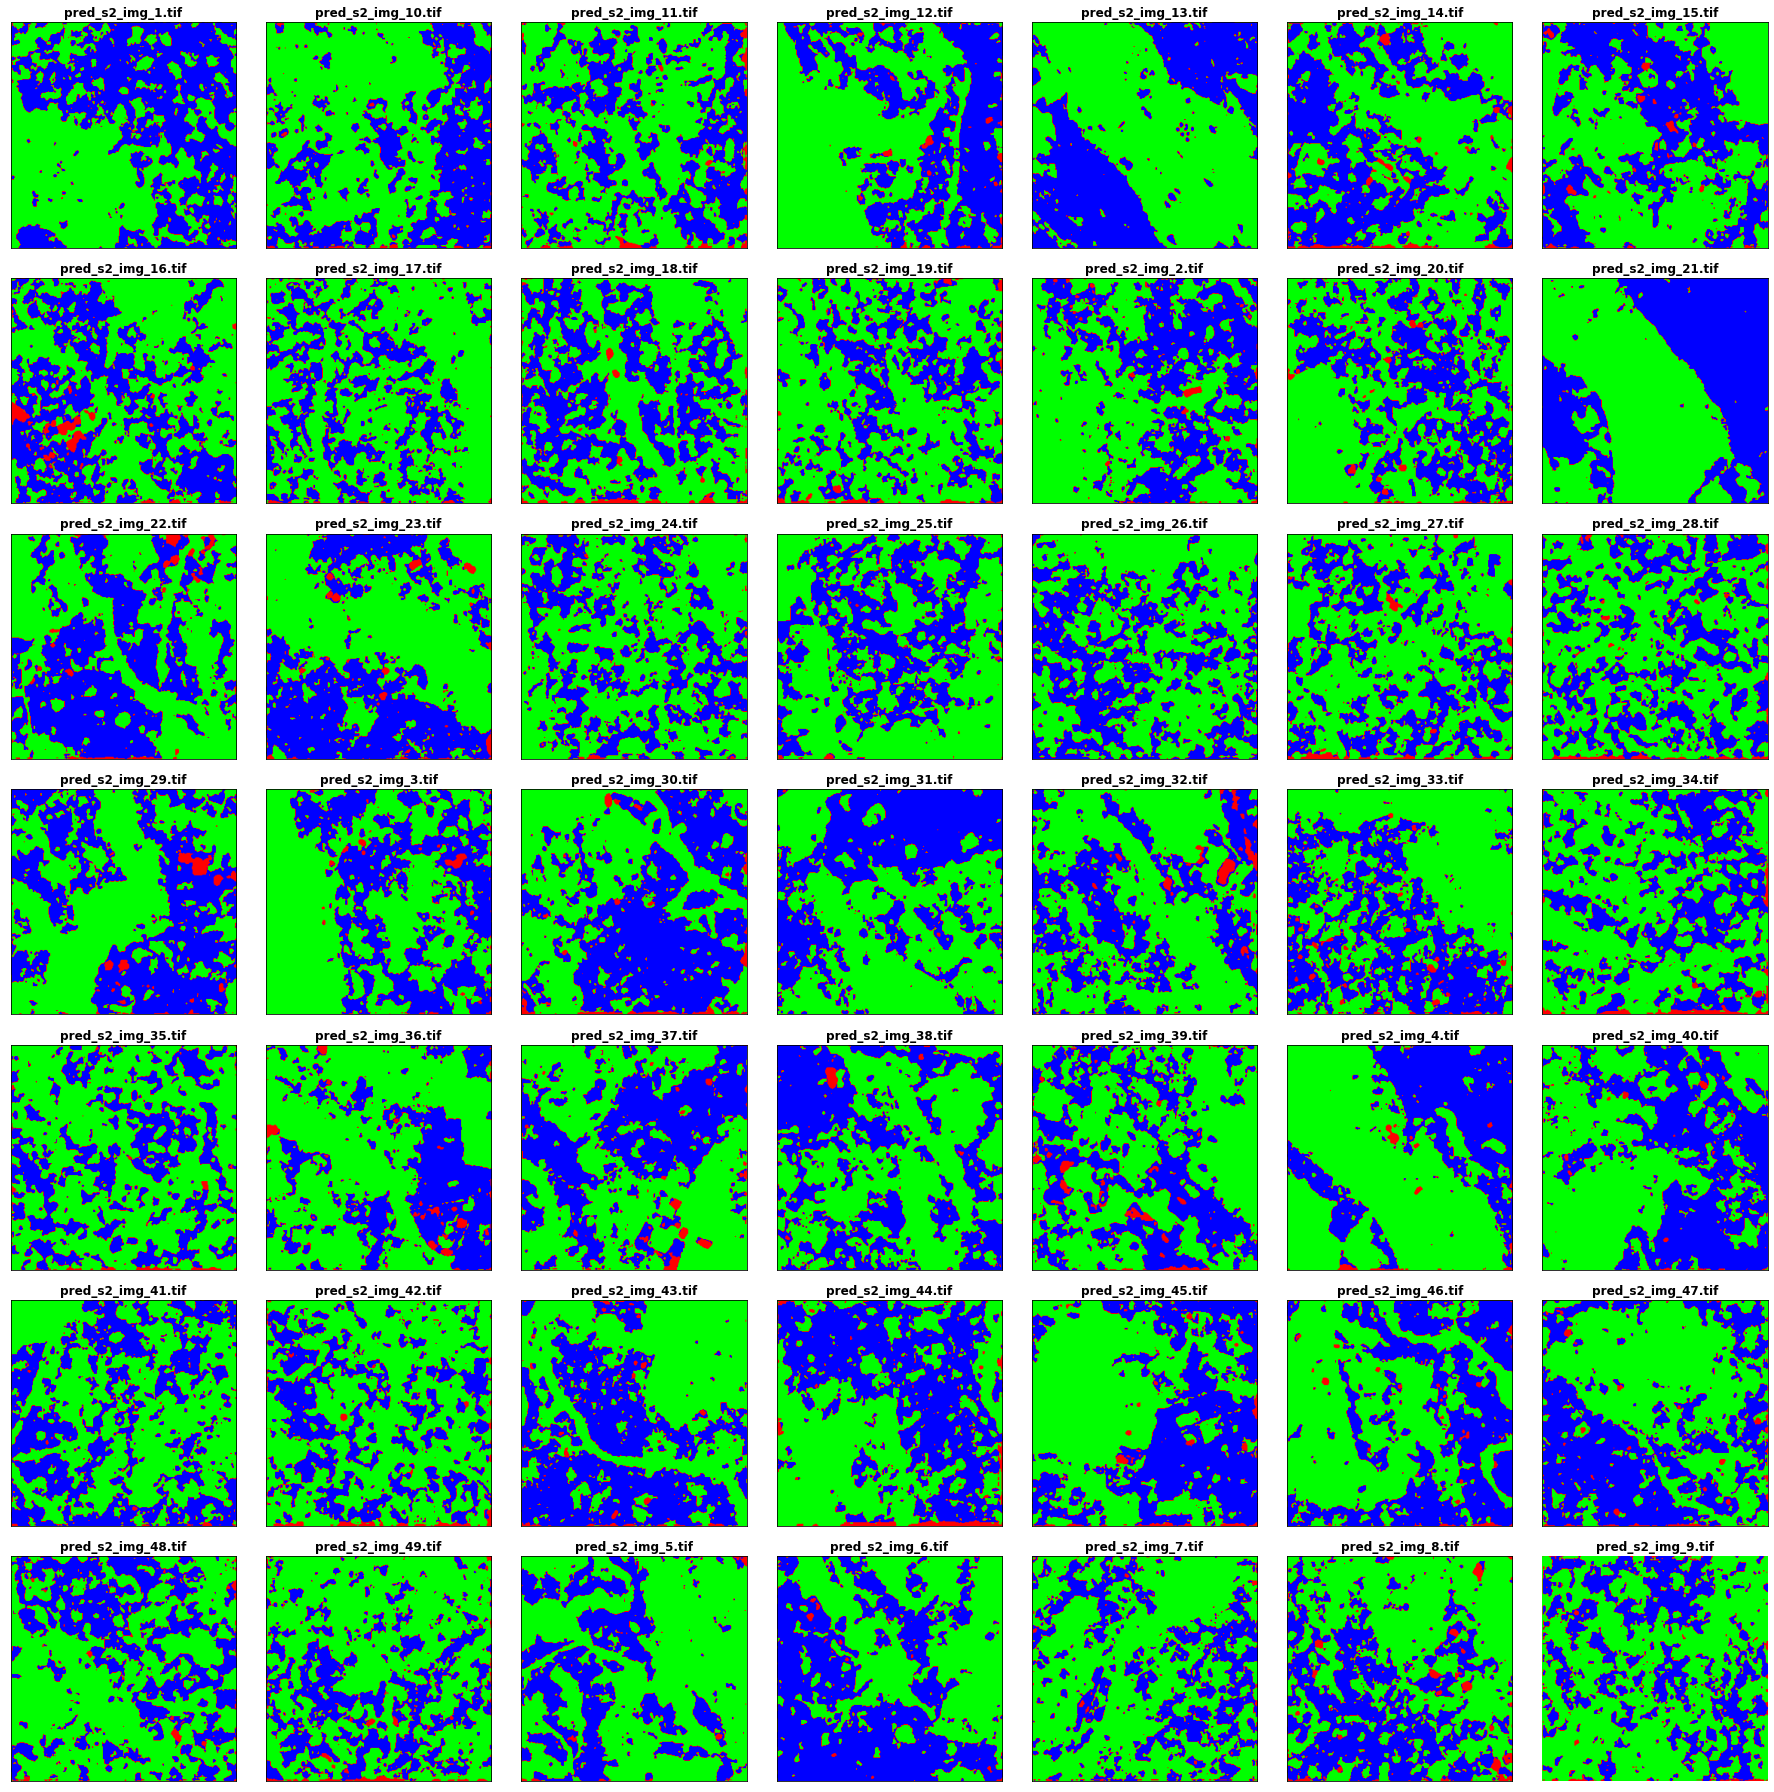

In [75]:
SAITAMA1 = '/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul18/'
plot_predictions(SAITAMA1)

49


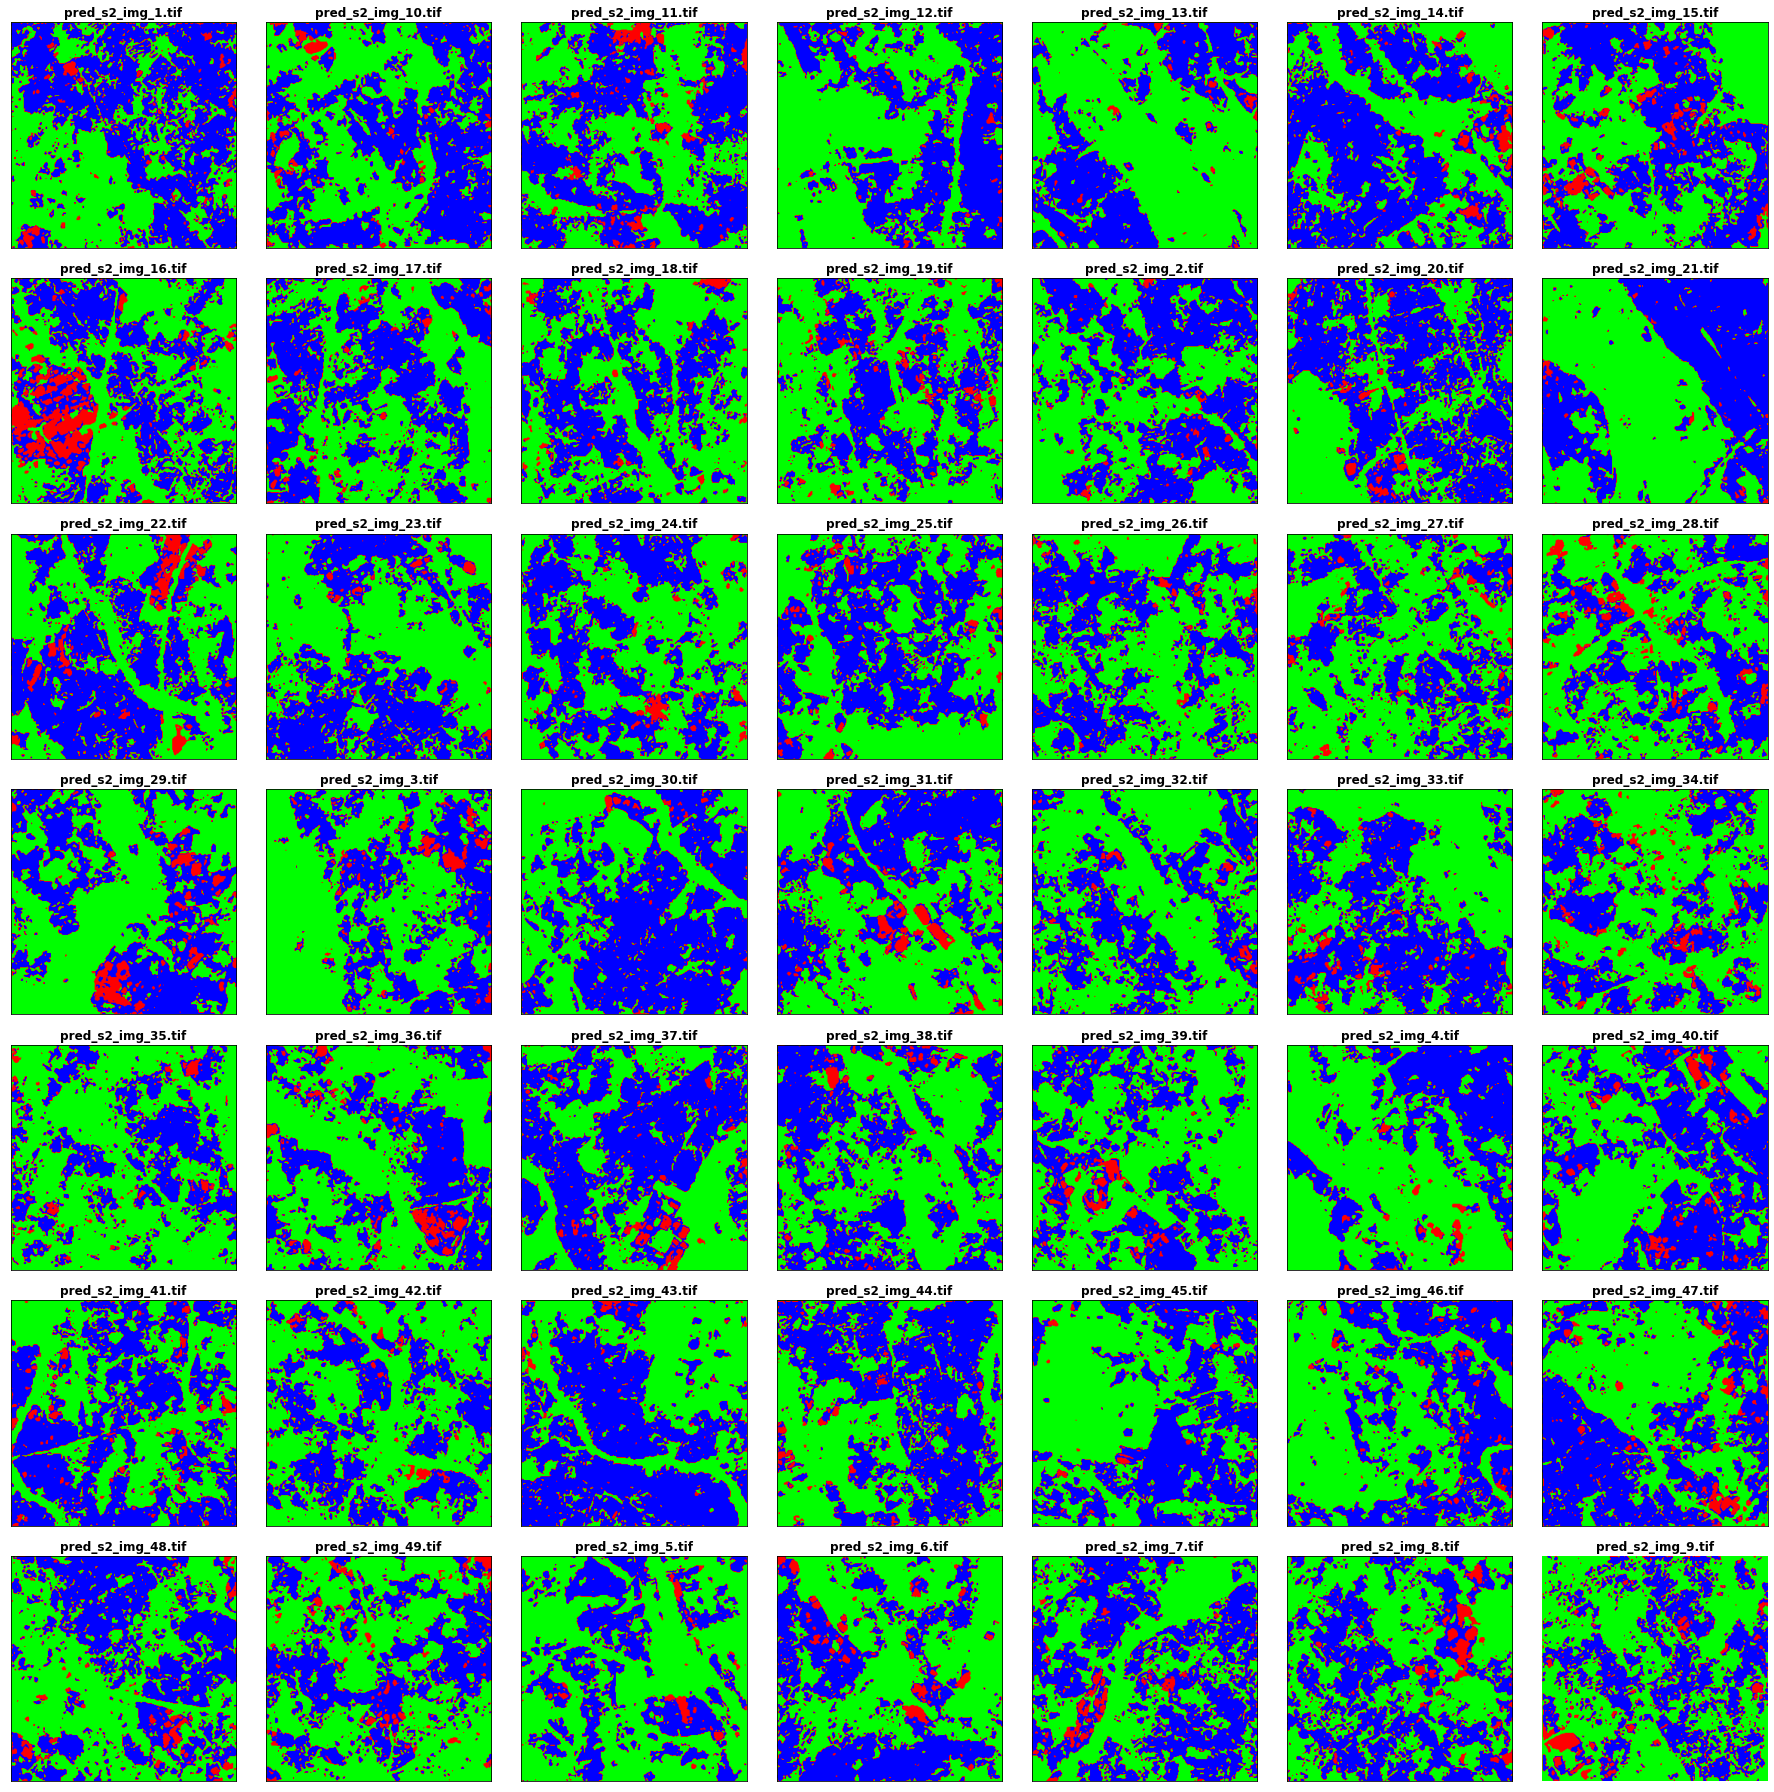

In [76]:
SAITAMA = '/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul26/'
plot_predictions(SAITAMA)

In [77]:
cols = ['datetime','model','num_epochs','loss_fn','batch_size','arch','optim','channels','pretrained','lr','num_val','trn_loss','val_loss','dice','augs','epoch_time']

# deeplab_results=pd.read_csv('logs/deeplab_results_log.csv',names=cols)
results=pd.read_csv(NB_DIR + '/logs/exp_results_log.csv').dropna()
results = results.drop(['Unnamed: 12'],axis=1)
results.columns = cols
results.head(3)

,datetime,model,num_epochs,loss_fn,batch_size,arch,optim,channels,pretrained,lr,num_val,trn_loss,val_loss,dice,augs,epoch_time
23,09/07/2022 17:44:15,unet,250,CrossEntropyLoss,4,resnet50,AdamW,15,False,0.00001,60,0.282557,0.877956,0.878845,['RandomRotate90'],0 days 00:00:00.037772
24,09/07/2022 20:18:18,unet,250,CrossEntropyLoss,4,resnet50,AdamW,15,False,0.00001,60,0.336650,0.872185,0.872707,"['RandomSizedCrop', 'PadIfNeeded', 'RandomRotate90']",0 days 00:00:00.037518
25,10/07/2022 06:43:25,unet,250,CrossEntropyLoss,4,resnet50,AdamW,15,False,0.00010,60,0.309096,0.862451,0.863112,['RandomRotate90'],0 days 00:00:00.028986


In [78]:
report_cols=list(results.columns)
results = results[report_cols].fillna(0.0)
nn_results = results.drop(['channels','pretrained'],axis=1)

## Compare archs vs Val loss , Dice


In [79]:
# results.groupby('arch').max('dice').sort_values(by='dice',ascending=False)
results.groupby('arch').max('dice').sort_values(by='dice',ascending=False)

,num_epochs,batch_size,channels,pretrained,lr,num_val,trn_loss,val_loss,dice
arch,,,,,,,,,
resnet50,500,16,15,False,0.05,60,0.714394,0.877956,0.879264


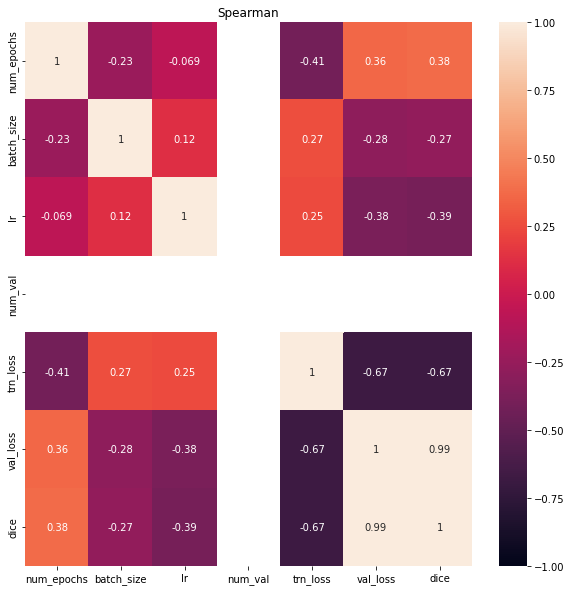

In [80]:
f,ax2 = plt.subplots(1,1,figsize=(10,10))
corr = nn_results.corr()
scorr = nn_results.corr(method = 'spearman')
# cm = 'cividis'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax2)#,cmap=cm)
ax2.set_title('Spearman')

plt.show()

In [81]:
import re
df = pd.DataFrame(columns=['loss_func','val_loss','Dice'])
loss_fncs=results['loss_fn'].str.split(',')
for i,result in enumerate(loss_fncs):
  
  if(result[0].startswith('DiceFocalLoss')):
    alpha,gamma=float(result[2]),float(result[3])
  else:
    alpha,gamma=np.nan,np.nan
  
  loss_func = re.sub('[^A-Za-z]+', '', result[0])
  df.loc[len(df)] = loss_func, \
                    float(results.iloc[i]['val_loss']), \
                    float(results.iloc[i]['dice'])
  # print(result[i][3],result[i][4])
np.unique(df['loss_func'])

array(['CrossEntropyLoss', 'FocalLoss'], dtype=object)

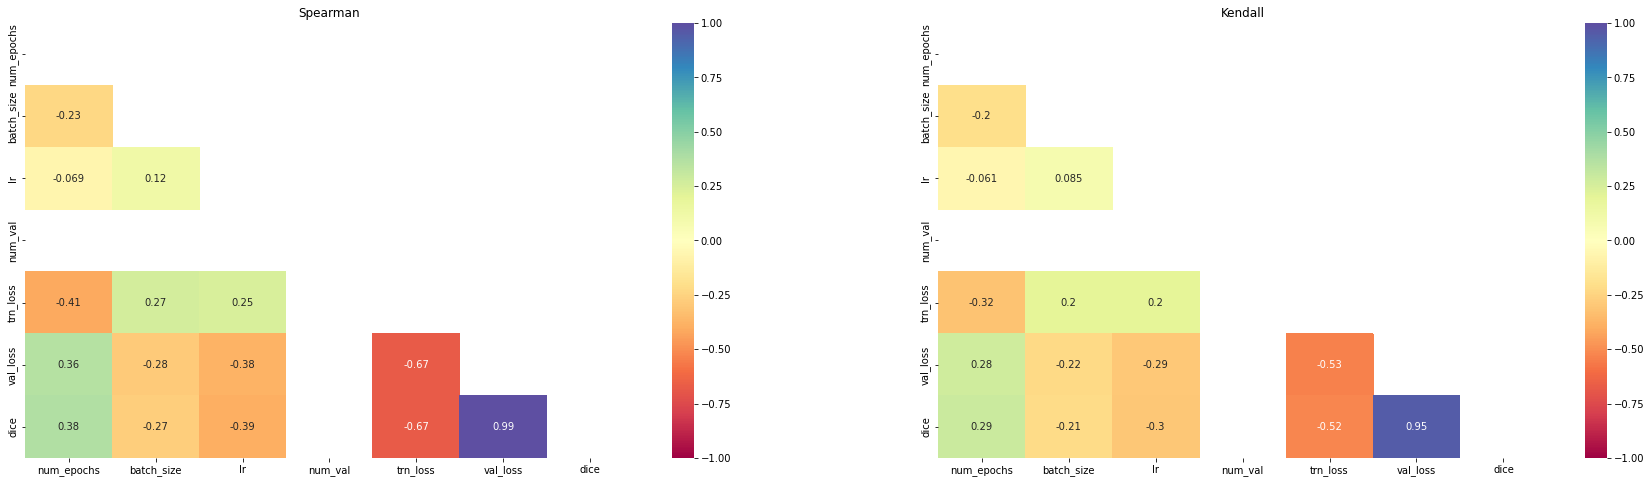

In [82]:

f,(ax1,ax2) = plt.subplots(1,2,figsize=(30,8))
# corr = nn_results.corr()
scorr = nn_results.corr(method = 'spearman')
kcorr = nn_results.corr(method = 'kendall')

# Generate a mask for the upper triangle
smask = np.triu(np.ones_like(scorr, dtype=bool))
kmask = np.triu(np.ones_like(kcorr, dtype=bool))

cm = 'Spectral'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm,mask=smask)
ax1.set_title('Spearman')
sns.heatmap(kcorr, annot = True,vmin=-1,vmax=1,ax=ax2,cmap=cm,mask=kmask)
ax2.set_title('Kendall')

plt.show()


In [83]:
# nn_results['epoch_time'] = nn_results['epoch_time'].str.replace(':', '').astype(float)
# nn_results['epoch_time'].head()

Text(0.5, 1.0, 'Validation loss and Dice score correlation')

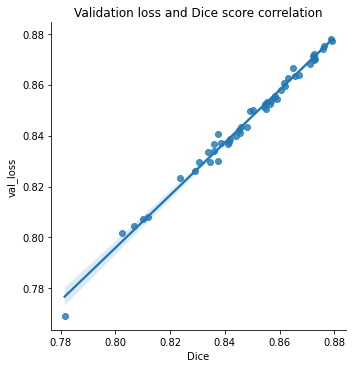

In [84]:
sns.lmplot(x='Dice',y='val_loss',data=df,fit_reg=True) 
plt.title('Validation loss and Dice score correlation')

In [85]:
# results.to_csv('results_log.csv', mode='a', index=False, header=False)
# scores_cols=['acc','per_cls_acc','IoU',	'Dice']
scores_cols=['dice']
# results[scores_cols].plot.bar()

In [86]:
print('best mean score: {}'.format(results[scores_cols].mean(axis=1).max()))
# results.iloc[results[scores_cols].mean(axis=1).argmax()]

best mean score: 0.879264040651801


# Compare various hyper params and architechtures results

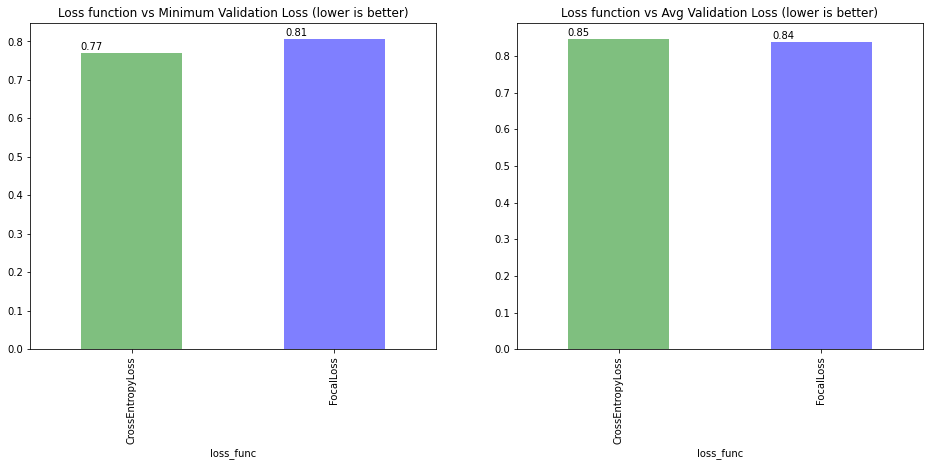

In [87]:
colors=['Green','Blue','Orange','Red','Purple']
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['val_loss'].min().plot.bar(title='Loss function vs Minimum Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax1)
annotate(ax1)

df.groupby('loss_func')['val_loss'].mean().plot.bar(title='Loss function vs Avg Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax2)
annotate(ax2)

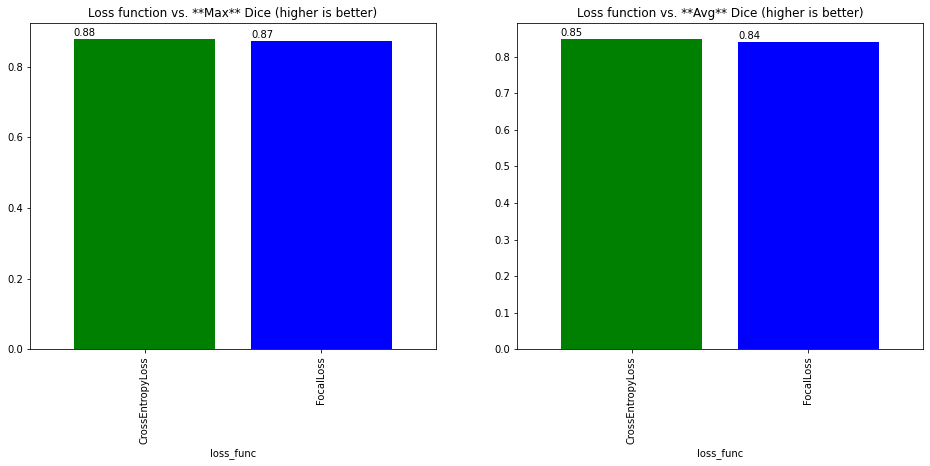

In [88]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['Dice'].max().plot.bar(title='Loss function vs. **Max** Dice (higher is better)',ax=ax1,width=0.8,color=colors)
annotate(ax1)

df.groupby('loss_func')['Dice'].mean().plot.bar(title='Loss function vs. **Avg** Dice (higher is better)',ax=ax2,width=0.8,color=colors)
annotate(ax2)


In [89]:
df.iloc[df['Dice'].argmax()]

loss_func    CrossEntropyLoss
val_loss             0.877295
Dice                 0.879264
Name: 18, dtype: object

### Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data